In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib


In [2]:
# Load the dataset
df = pd.read_csv("tested.csv")  # Adjust the filename if necessary

# Display dataset information
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB
None
   PassengerId  Survived  Pclass  \
0          892         0       3   
1          893         1       3   
2          894         0       2   
3          895         0       3   
4          896         1       3   

                      

In [3]:
# Check missing values
print(df.isnull().sum())

# Fill missing age values with median age
df["Age"].fillna(df["Age"].median(), inplace=True)

# Fill missing embarked values with the most common port
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

# Drop the 'Cabin' column due to too many missing values
df.drop(columns=["Cabin"], inplace=True)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


C:\Users\intel\AppData\Local\Temp\ipykernel_15152\522231163.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Age"].fillna(df["Age"].median(), inplace=True)
C:\Users\intel\AppData\Local\Temp\ipykernel_15152\522231163.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [4]:
# Encode categorical features
label_encoders = {}
categorical_cols = ["Sex", "Embarked"]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders for later use


In [5]:
scaler = StandardScaler()
df["Fare"] = scaler.fit_transform(df[["Fare"]])  # Scale fare feature


In [6]:
# Extract title from names
df["Title"] = df["Name"].apply(lambda name: name.split(",")[1].split(".")[0].strip())

# Group rare titles
rare_titles = ["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"]
df["Title"] = df["Title"].replace(rare_titles, "Rare")

# Encode titles
df["Title"] = LabelEncoder().fit_transform(df["Title"])

# Family size
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1


In [7]:
# Define features and target variable
X = df.drop(columns=["Survived", "Name", "Ticket", "PassengerId"])  # Features
y = df["Survived"]  # Target variable

# Split data into train and test sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [9]:
xgb_model = XGBClassifier(objective="binary:logistic", n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [10]:
# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n🔹 {model_name} Evaluation:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")



🔹 Random Forest Evaluation:
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

Confusion Matrix:
 [[50  0]
 [ 0 34]]

🔹 XGBoost Evaluation:
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

Confusion Matrix:
 [[50  0]
 [ 0 34]]


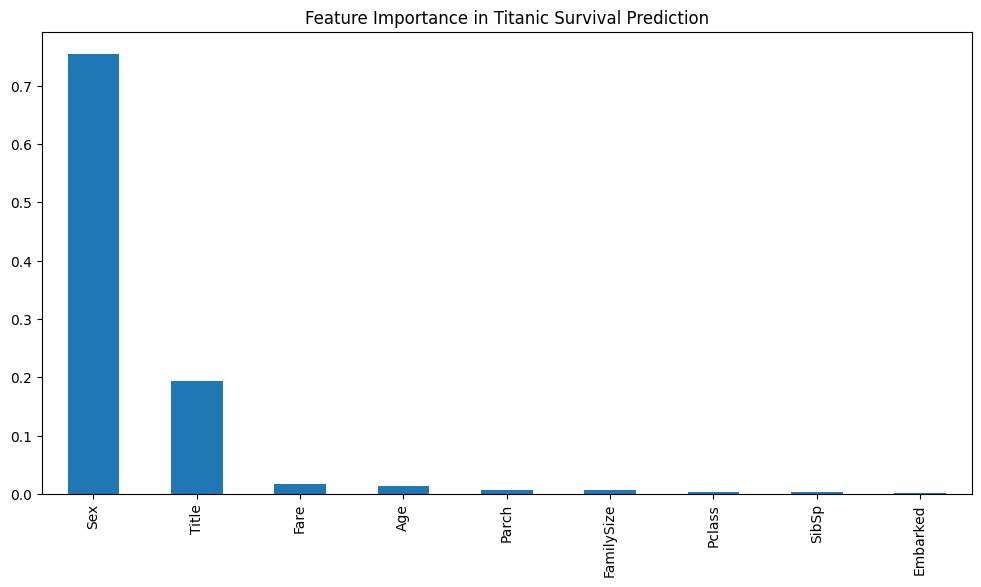

In [11]:
# Extract feature importance from Random Forest
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind="bar", figsize=(12, 6))
plt.title("Feature Importance in Titanic Survival Prediction")
plt.show()


In [ ]:
def predict_survival(model, pclass, sex, age, sibsp, parch, fare, embarked, title, family_size):
    # Convert categorical inputs using the stored label encoders
    sex_encoded = label_encoders["Sex"].transform([sex])[0]
    embarked_encoded = label_encoders["Embarked"].transform([embarked])[0]

    # Standardize fare
    fare_scaled = scaler.transform([[fare]])[0][0]

    # Create input array
    input_data = np.array([[pclass, sex_encoded, age, sibsp, parch, fare_scaled, embarked_encoded, title, family_size]])
    
    # Make prediction
    predicted_survival = model.predict(input_data)[0]
    return "Survived" if predicted_survival == 1 else "Not Survived"

# Example 
predicted_status = predict_survival(rf_model, 3, "male", 25, 0, 0, 50, "S", 2, 1)
print(f"\nPredicted Survival Status: {predicted_status}")



Predicted Survival Status: Not Survived


c:\Users\intel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\intel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [13]:
# Save the trained models and encoders
joblib.dump(rf_model, "random_forest_model.pkl")
joblib.dump(xgb_model, "xgboost_model.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']